In [52]:
import os
import sklearn.feature_extraction.text as text
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import scipy.spatial.distance as scidist
import numpy as np

def load_directory(directory, max_length):
    documents, authors, titles = [], [], []
    for filename in os.scandir(directory):
        if not filename.name.endswith('.txt'):
            continue
        author, _ = os.path.splitext(filename.name)
        
        with open(filename.path) as f:
            contents = f.read()
        lemmas = contents.lower().split()
        start_idx, end_idx, segm_cnt = 0, max_length, 1
    
        while end_idx < len(lemmas):
            documents.append(' '.join(lemmas[start_idx:end_idx]))
            authors.append(author[0])
            title = filename.name.replace('.txt', '').split('_')[1]
            titles.append(f'{title}-{segm_cnt}')
            start_idx += max_length
            end_idx += max_length
            segm_cnt += 1 
    
    return documents, authors, titles

In [55]:
documents, authors, titles = load_directory('./hac_data', 10000)
authors

['f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h']

In [56]:
vectorizer = text.CountVectorizer()
v_documents = vectorizer.fit_transform(documents).toarray()
v_documents = preprocessing.normalize(v_documents.astype(float), norm='l1')

scaler = preprocessing.StandardScaler()
s_documents = scaler.fit_transform(v_documents)
test_doc = s_documents[0]
distances = [scidist.cityblock(test_doc, train_doc) for train_doc in s_documents[1:]]
print(authors[np.argmin(distances) + 1])

h


In [57]:
test_size = len(set(authors)) * 2
(train_documents, test_documents, train_authors, test_authors) = model_selection.train_test_split(
    v_documents,
    authors, 
    test_size=test_size,
    stratify=authors,
    random_state=1
)

print(f'N={test_documents.shape[0]} test documents with '
    f'V={test_documents.shape[1]} features.')

print(f'N={train_documents.shape[0]} test documents with '
    f'V={train_documents.shape[1]} features.')

N=4 test documents with V=31187 features.
N=105 test documents with V=31187 features.


In [58]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_documents)
train_documents = scaler.transform(train_documents)
test_documents = scaler.transform(test_documents)
distances = scidist.cdist(test_documents, train_documents, metric='cityblock')

nn_predictions = np.array(train_authors)[np.argmin(distances, axis=1)]
print(nn_predictions[:3])


['h' 'h' 'h']


In [59]:
class Delta:

    def fit(self, X, y):
        self.train_y = np.array(y)
        self.scaler = preprocessing.StandardScaler(with_mean=False)
        self.train_X = self.scaler.fit_transform(X)
        return self

    def predict(self, X, metric='cityblock'):
        X = self.scaler.transform(X)
        dists = scidist.cdist(X, self.train_X, metric=metric)
        return self.train_y[np.argmin(dists, axis=1)]

In [60]:
import sklearn.metrics as metrics

delta = Delta()
delta.fit(train_documents, train_authors)
preds = delta.predict(test_documents)

for true, pred in zip(test_authors, preds):
    _connector = 'WHEREAS' if true != pred else 'and' 
    print(f"Observed author is {true} {_connector} {pred} was predicted.")

accuracy = metrics.accuracy_score(preds, test_authors)
print(f"\nAccuracy of predictions: {accuracy:.1f}")

Observed author is h and h was predicted.
Observed author is f WHEREAS h was predicted.
Observed author is h and h was predicted.
Observed author is f WHEREAS h was predicted.

Accuracy of predictions: 0.5


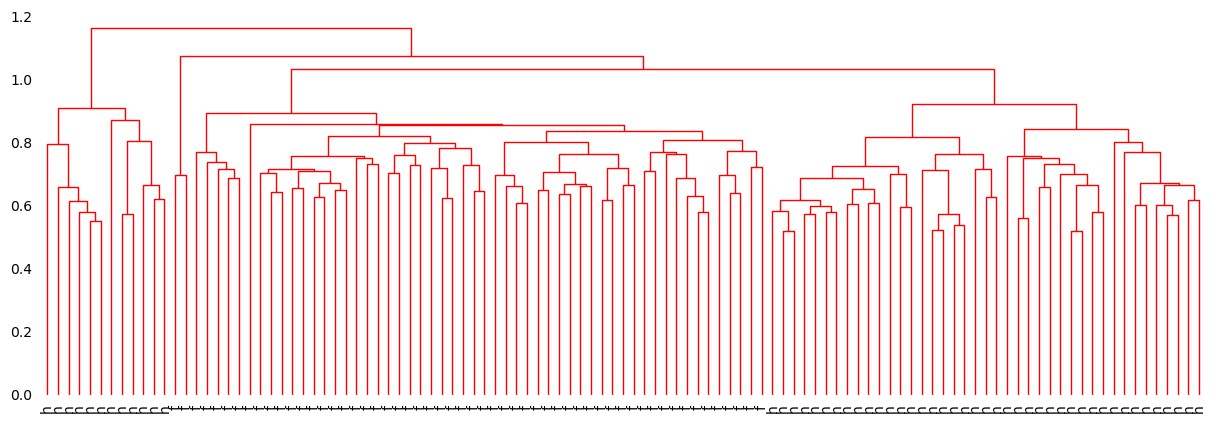

In [61]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy

dm = scidist.pdist(v_documents, 'cityblock')
linkage_object = hierarchy.linkage(dm, method='complete')

def plot_tree(linkage_object, labels, figsize=(15, 5), ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object,
            labels=labels,
            ax=ax,
            link_color_func=lambda c: 'red', 
            leaf_font_size=10,
            leaf_rotation=90
        )
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

plot_tree(linkage_object, authors)

[Text(0.5, 0, 'PC1'), Text(0, 0.5, 'PC2')]

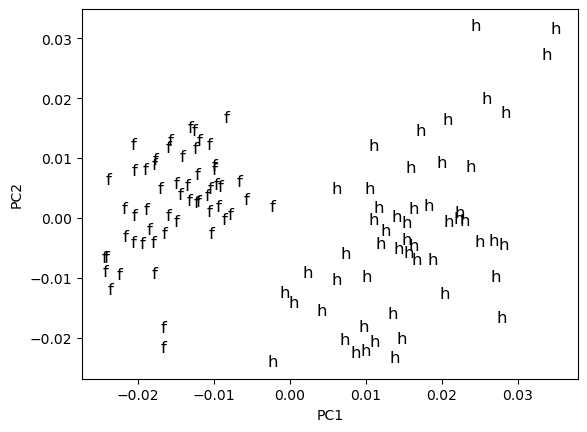

In [62]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(v_documents)

c1, c2 = documents_proj[:, 0], documents_proj[:, 1]

fig, ax = plt.subplots()
ax.scatter(c1, c2, facecolors='none')
for p1, p2, author in zip (c1, c2, authors):
    ax.text(p1, p2, author[0], fontsize=12, ha='center', va='center')

ax.set(xlabel="PC1", ylabel="PC2")

In [70]:
def load_data(folder_path):
    root_folder = folder_path

    #filenames = []
    text_data = [] # Replace with the text data
    labels = [] # Replace with the corresponding labels (0 or 1)

    for subfolder in os.listdir(root_folder):
        subfolder_path = os.path.join(root_folder, subfolder)

        if subfolder == 'fitzgerald':
            label = 0
        else:
            label = 1

        for file in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file)
            print("Processing file:", file)
            with open(file_path, 'r', encoding="utf-8") as f:
                text = f.read()
            text_data.append(text)
            labels.append(label)
    return text_data, labels

In [78]:
from pathlib import Path
path = Path(r'C:\Users\KSpicer\Documents\GitHub\fitzgerald_hemingway\data')
print(path)
text_data, labels = load_data(path)
print(len(labels))

C:\Users\KSpicer\Documents\GitHub\fitzgerald_hemingway\data
Processing file: fitzgerald_all_the_sad.txt
Processing file: fitzgerald_beautiful_and_damned.txt
Processing file: fitzgerald_flappers_and_philosophers.txt
Processing file: fitzgerald_gatsby.txt
Processing file: fitzgerald_tales_jazz_age.txt
Processing file: fitzgerald_tender_is.txt
Processing file: fitzgerald_the_vegtable.txt
Processing file: fitzgerald_this_side.txt
Processing file: hemingway_across_the_river.txt
Processing file: hemingway_bell_tolls.txt
Processing file: hemingway_farewell.txt
Processing file: hemingway_green_hills_africa.txt
Processing file: hemingway_in_our_time.txt
Processing file: hemingway_men_without_women.txt
Processing file: hemingway_old_man.txt
Processing file: hemingway_sun_also.txt
Processing file: hemingway_three_stories_ten_poems.txt
Processing file: hemingway_winner_take_nothing.txt
18


In [79]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [80]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# create a pipeline to vectorize the text and perform PCA
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('pca', PCA(n_components=2)),
    ('classifier', LogisticRegression())
])

text_data_train, text_data_test, labels_train, labels_test = train_test_split(
    text_data, labels, test_size=0.2, random_state=42
)
# fit the pipeline to the text data and labels
pipeline.fit(text_data, labels)

score = pipeline.score(text_data_test, labels_test)
print("Test accuracy:", score)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.